In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.signal import butter, sosfiltfilt, find_peaks

In [113]:
epoch_seconds = 5.2
second_per_sample = 0.004
epoch = int(epoch_seconds / second_per_sample)

def high_pass(data):
    """
    Applies a high pass filter to the voltage data in the dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the high pass filter
    cutoff_freq = 1

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    sos = butter(filter_order, normalized_cutoff_freq, btype='highpass', output='sos')

    # Apply the filter to the voltage data
    voltage_chan_1 = sosfiltfilt(sos, voltage_chan_1)
    voltage_chan_2 = sosfiltfilt(sos, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})

def low_pass(data):
    """
    Applies a low pass filter to the voltage data in a Pandas dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the low pass filter
    cutoff_freq = 5

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    sos = butter(filter_order, normalized_cutoff_freq, btype='lowpass', output='sos')

    # Apply the filter to the voltage data
    voltage_chan_1 = sosfiltfilt(sos, voltage_chan_1)
    voltage_chan_2 = sosfiltfilt(sos, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})

def divide_dataset(data, time):
    num_epoch = math.ceil(len(time) / epoch)
    data_subsets = []
    time_subsets = []
    start = 0
    for i in range(num_epoch):
        if start + epoch >= len(time):
            data_subsets.append(data.iloc[start:,:])
            time_subsets.append(time[start:])       
        else:
            data_subsets.append(data.iloc[start:start + epoch,:])
            time_subsets.append(time[start:start + epoch])
            start = start + epoch
    return data_subsets, time_subsets

def invert_data(data):
    # negative values become positive, while positive values become negative in channel 1 and channel 2
    data.iloc[:,0] = -data.iloc[:,0]
    data.iloc[:,1] = -data.iloc[:,1]
    return data

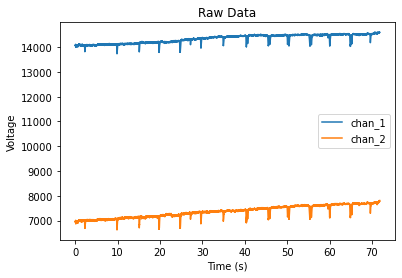

After applying high pass filter


C:\Users\ctric\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


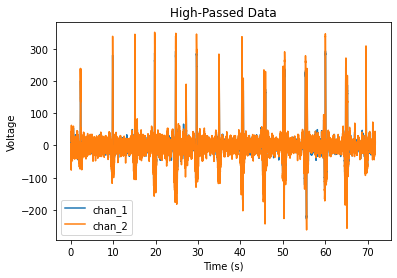

After applying low pass filter


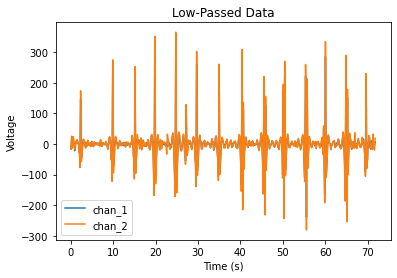

Single blink:


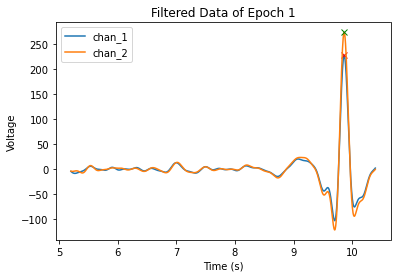

Double blink:


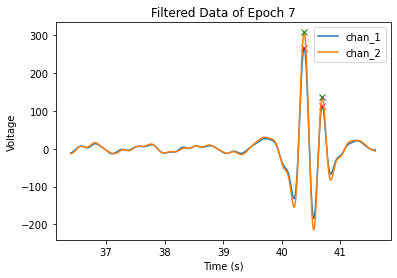

In [118]:
df = pd.read_csv('Subject_4/CSV/BrainFlow-RAW_2023-03-07_11-46-58_44.csv', delimiter='\t')

df = df.loc[6:,:]
# invert_data(df)
data = df.iloc[:,1:3]
time = [x * second_per_sample for x in range(len(df))]
df.insert(24, 'time', time)
time = df.iloc[:, -1]

# Visualize the raw eye blink data
plt.plot(time, data.iloc[:, 0], label='chan_1')
plt.plot(time, data.iloc[:, 1], label='chan_2')
plt.title("Raw Data")
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

chan1 = -data.iloc[:,0]
chan2 = -data.iloc[:,1]

data.iloc[:,0] = chan1
data.iloc[:,1] = chan2


filtered = high_pass(data)
print("After applying high pass filter")
# Visualize the data after applying the high pass filter
plt.plot(time, filtered.iloc[:, 0], label='chan_1')
plt.plot(time, filtered.iloc[:, 1], label='chan_2')
plt.title("High-Passed Data")
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()


filtered = low_pass(filtered)
print("After applying low pass filter")
# Visualize the data after applying the low pass filter
plt.plot(time, filtered.iloc[:, 0], label='chan_1')
plt.plot(time, filtered.iloc[:, 1], label='chan_2')
plt.title("Low-Passed Data")
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

filtered_subset, time_subset = divide_dataset(filtered, time)

print("Single blink:")
for i in range(1,2): # change to (0,num_epoch + 1) to see plots of all epochs
    reset_index = filtered_subset[i]['FP1 (channel 1)'].reset_index(drop=True)
    time_index = time_subset[i].reset_index(drop=True)
    reset_index
    peak, _ = find_peaks(reset_index, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_index[peak], reset_index[peak], "x", color ='red')

    reset_index_2 = filtered_subset[i]['FP2 (channel 2)'].reset_index(drop=True)
    peak_2, _ = find_peaks(reset_index_2, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.plot(time_index[peak_2], reset_index_2[peak_2], "x", color ='green')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()
print("Double blink:")
for i in range(7,8): # change to (0,num_epoch + 1) to see plots of all epochs
    reset_index = filtered_subset[i]['FP1 (channel 1)'].reset_index(drop=True)
    time_index = time_subset[i].reset_index(drop=True)
    reset_index
    peak, _ = find_peaks(reset_index, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_index[peak], reset_index[peak], "x", color ='red')

    reset_index_2 = filtered_subset[i]['FP2 (channel 2)'].reset_index(drop=True)
    peak_2, _ = find_peaks(reset_index_2, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.plot(time_index[peak_2], reset_index_2[peak_2], "x", color ='green')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()